In [ ]:
# Windtunnel Package Setup
from deploy_config import install_windtunnel, verify_installation

# Install and verify windtunnel package
if not install_windtunnel():
    print("❌ Installation failed. Please check your internet connection.")
else:
    verify_installation()


📦 Installing windtunnel package from GitHub...
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/se04ber/WTSoftwareUtilitiesShare.git to /tmp/pip-req-build-j5lyim_n


  Running command git clone --filter=blob:none --quiet https://github.com/se04ber/WTSoftwareUtilitiesShare.git /tmp/pip-req-build-j5lyim_n


  Resolved https://github.com/se04ber/WTSoftwareUtilitiesShare.git to commit 8ce0caf45914af6119e5bf9ecad1f941cc5e7754
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


In [ ]:
# Data source configuration
USE_GITHUB_EXAMPLE_DATA = True  # Set to False to use local data
#Else use your own Data in Folder Data/(your_data_folder)/measurement_prefix*, ...
DATA_FOLDER_NAME = "your_data_folder"          #name of folder inside Data/InputData/ f.e. Umrechnung zur Kontrolle / 
PARAMETER_FILE_NAME = "ambient_conditions.csv" #name of parameterFile inside ParameterFiles f.e. ambient_conditions_.UBA_GA.csv
MEASUREMENT_PREFIX = "your_measurement_prefix" #Prefix of all time series files inside DATA_FOLDER_NAME f.e. UBA_GA_02_04_01_000_1_001

# Data Setup and Configuration
from deploy_config import setup_folder_structure, setup_github_data, setup_local_data
# Setup folder structure and data
base_dir, data_dir, input_dir, param_dir, results_dir = setup_folder_structure()
if USE_GITHUB_EXAMPLE_DATA:
    path_dir, path, csv_file, output_path, namelist = setup_github_data(input_dir, param_dir, results_dir)
else:
    # Local data configuration
    DATA_FOLDER_NAME = DATA_FOLDER_NAME
    PARAMETER_FILE_NAME = PARAMETER_FILE_NAME 
    MEASUREMENT_PREFIX = MEASUREMENT_PREFIX
    path_dir, path, csv_file, output_path, namelist = setup_local_data(
        input_dir, param_dir, results_dir, DATA_FOLDER_NAME, PARAMETER_FILE_NAME, MEASUREMENT_PREFIX
    )
print(f"✅ Setup complete! Data path: {path}, Output: {output_path}")


In [ ]:
# Analysis Parameters
# Measurement configuration
parameters_PerFolder = False

# Variables and Parameters set for all ts, if no ambient_conditions.csv file overgiven
# If at the end calculate entdimensionalised or full scale transform quantities
# Default: nd:entdimensionalise, ms:model scale, fs:full scale.    
full_scale='ms'
# Postprocessing before analysis
applyPostprocessing=True
averageInterval=60 # s  # Interval to downaverage raw time series to before analysis
measurementFreq=0.005 # Time series frequency # For now only for static case implemented
averagingColumns=["net_concentration"] # Columns to average dow
# Saving settings: (output_path for path)
osType = "Linux" # Windows  # For Path
outputName = None # Default: ts name

saveTs=True    # Only save time series of concentration quantities to separat files
saveAvg=True # Save average of ts of concentration quantities to separat files
saveStats=True # Save averages, percentile95/5, peak2mean of ts of concentration quantities to separat files
saveCombined=True # Save all averages and statistics for all files to one combined file
combinedFileName="combined_file_nora.csv"
base_path=None # base_path = output_path + "Files/Point_Data_stats/UBA_thesi/" # Base path for getting files for combined files, if None

saveAll=True # Sets saveTs, saveAvg and saveStats, saveCombined to True, saving ts, averages, statistics and combined file

# Uncertainty calculation and saving
calculateUncertainty=True # Calculate measurement uncertainties based on repeated measurements
saveUncertainties=True # Add uncertainty columns to saved files
saveConfigNames=True # Add config_name column to combined files
split_factor=1.8 # Factor for splitting long time series in uncertainty calculation
uncertainty_threshold=1e-4 # Threshold for relative deviation calculation
verboseUncertainty=True # Print detailed logging for uncertainty calculation
uncertaintyMetrics=None # Metrics to calculate uncertainties for: ["Mean", "Median", "Peak2Mean", "P95"] or None for all
uncertaintyConcentrationTypes=None # Concentration types: ["c_star", "net_concentration", "full_scale_concentration"] or None for c_star only
includeAbsoluteUncertainty=True # Include absolute uncertainty values (_uncertainty_abs)
includePercentageUncertainty=True # Include percentage uncertainty values (_uncertainty_pct)

# Column selection for combined files
columnsToSave=None # None=default columns, or provide list e.g. ["Avg_c_star [-]", "X_fs [m]"]

# Legacy uncertainty (for plotting)
uncertainty_value=None # Manual uncertainty value for error bars
uncertainty_representation="percentage" # "absoluteValue"

print("✅ Analysis parameters configured!")


In [ ]:
#Example file/Default environment values if no csv_file found:

#Source location  [mm]
x_source=0
y_source=0
z_source=0
#Source mass flow controller, calibration settings
mass_flow_controller=0.300 #0.600#Stickstoffdurchflussregler #[l/h]*1/100 #'X'  #Controller(settings) used, just a name placeholder for orientation, not used yet
#If calibration performed on a controller, corrects actual max. flow capacity of controller
calibration_curve=1.0     #0.3     #0.3 oder 3
calibration_factor=0 #1      #
#Gas characteristics
gas_name='C12'           #Just placeholder name variable for orientation, not used for anything
gas_factor=0.5   #[-]    #!!! Needs to be calculate/specificate f.e. if gas changes 
mol_weight=29.0 #28.97 #Air [g/mol]
#Measurement location [mm]
x_measure=1020 #855.16
y_measure= 0    #176.29
z_measure= 5     #162
#Surrounding conditions
pressure=101426.04472        #1009.38  #[hPa] ->Pa
temperature=23             #23.5  #[°C]
#Model to Reality scaling
scale=400                     #250      #Model/Reality
scaling_factor=0.5614882               #0.637       #USA1 to selected ref pos.?
ref_length=1/400              #1/250           #Lref
ref_height=100/400            #None            #Href
#Full Scale Parameters
full_scale_wtref=10             #6         #Uref_fullscale
full_scale_flow_rate=0.002     #Q_amb[kg/s]?   #0.5   #Qv_fullscale
full_scale_temp=20             #[°C]
full_scale_pressure=101325     #[Pa]
#Q_ambient[kg/s] ->  Q[m³/s]=Q[kg/s]*R*T/(M*p)
#Variable wdir for wind direction. To be implemented in future. ##
#wdir=0
#Variable axis_range. Reserved for future implementation of axis range specification, 
#analogously to puff mode
#axis_range='auto'


In [ ]:
#Imports
import windtunnel as wt
import os
import sys
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib
import warnings
# Suppress pandas warnings about attribute access (these are just warnings, not errors)
warnings.filterwarnings("ignore", message="Pandas doesn't allow columns to be created via a new attribute name")
from windtunnel.concentration.CompareDatasets import *
# Reload utils module to get latest changes
if 'windtunnel.concentration.utils' in sys.modules:
    importlib.reload(sys.modules['windtunnel.concentration.utils'])
#Edited Nora: Check if ambient conditions file is even there, before trying out reading-in
print(f"CSV erwartet unter: {csv_file}")
if os.path.exists(csv_file):
    print("✅ CSV-Datei gefunden.")
else:
    print("❌ CSV-Datei NICHT gefunden.")
    print("Folgende Dateien sind im Ordner vorhanden:")
    for f in os.listdir(path):
        print(f)

path = path + "/"
#Initialize uncertainty results
uncertainty_results = {}
        
###### Initialise concentration ts dictionary of length namelist, as well as for full scale and entdimensionalised
conc_ts = {}
conc_ts.fromkeys(namelist)
conc_ts_fs = conc_ts
conc_ts_nd = conc_ts

dict_conc_ts = conc_ts
dict_conc_nd = conc_ts
dict_conc_fs = conc_ts

data_dict = {}
data_dict.fromkeys(namelist)

#Read in ambient conditions for each folder or concentration ts from given csv file or for same conditions from manually
parameters_PerFolder = parameters_PerFolder #False  #True=for each folder/namelist entry new column, False: for each ts one column entry

for name in namelist:
    files = wt.get_files(path, name)
    print(f"files: {files}")

    #Initilise Dictionary for each given name containing dimensions of nr of files ts#0-
    conc_ts[name] = {}
    conc_ts[name].fromkeys(files)
    
    if parameters_PerFolder==True:
        #Read ambient conditions from csv file only for each folder
        ambient_conditions = wt.PointConcentration.get_ambient_conditions(path=path, name=name, input_file=csv_file)
        #print(ambient_conditions)
        #Else read/use given default from cell above
        if ambient_conditions is None:
            []
        #Read ambient conditions from csv file
        else:
            x_source, y_source, z_source, x_measure, y_measure, z_measure, pressure, temperature, calibration_curve, mass_flow_controller, calibration_factor, scaling_factor, scale, ref_length, \
            ref_height, gas_name, mol_weight, gas_factor, full_scale_wtref, full_scale_flow_rate, full_scale_temp, full_scale_pressure, config_name = wt.PointConcentration.read_ambient_conditions(
                ambient_conditions, name)
            
        
    for file in files:
        if parameters_PerFolder == False:
            #Read in ambient condition column for each ts
            ambient_conditions = wt.PointConcentration.get_ambient_conditions(path=path, name=file, input_file=csv_file)
            #Else read/use given default from cell above
            if ambient_conditions is None:
                []
            #Read ambient conditions from csv file
            else:
                x_source, y_source, z_source, x_measure, y_measure, z_measure, pressure, temperature, calibration_curve, mass_flow_controller, calibration_factor, scaling_factor, scale, ref_length, \
                ref_height, gas_name, mol_weight, gas_factor, full_scale_wtref, full_scale_flow_rate, full_scale_temp, full_scale_pressure,  config_name= wt.PointConcentration.read_ambient_conditions(
                ambient_conditions, file)

        conc_ts[name][file] = wt.PointConcentration.from_file(path + file)
    
        conc_ts[name][file].ambient_conditions(x_source=x_source, y_source=y_source, z_source=z_source,
                                               x_measure=x_measure, y_measure=y_measure, z_measure=z_measure,
                                               pressure=pressure,
                                               temperature=temperature,
                                               calibration_curve=calibration_curve,
                                               mass_flow_controller=mass_flow_controller,
                                               calibration_factor=calibration_factor,
                                               config_name=config_name)

        #Set read-in scaling, gas and full scale information to internal class variables
        print("Store information into PointConcentration class objects array")
        conc_ts[name][file].scaling_information(scaling_factor=scaling_factor, 
                                                scale=scale,
                                                ref_length=ref_length, 
                                                ref_height=ref_height)
        conc_ts[name][file].tracer_information(gas_name=gas_name,
                                               mol_weight=mol_weight,
                                               gas_factor=gas_factor)
        conc_ts[name][file].full_scale_information(full_scale_wtref=full_scale_wtref,
                                                   full_scale_flow_rate=full_scale_flow_rate,
                                                   full_scale_temp=full_scale_temp,full_scale_pressure=full_scale_pressure)

        #Calculate mass flow rate, net concentration and dimensionalise concentration
        print("Do main calculations")
        conc_ts[name][file].convert_temperature()
        conc_ts[name][file].calc_wtref_mean()
        
        conc_ts[name][file].calc_model_mass_flow_rate(usingMaxFlowRate="True",applyCalibration="False")
        conc_ts[name][file].calc_net_concentration()

        #conc_ts[name][file].clear_zeros()  #Remove values net_concentration =< 0 from dataset !noise
        conc_ts[name][file].calc_c_star()

        conc_ts[name][file].calc_full_scale_concentration() #Try

        #Transforming/Outputting data in full-scale, model scale, and non-dimensional
        print("Transform scale")
        if full_scale == 'ms':
            dict_conc_ts = conc_ts
            
        elif full_scale == 'fs':
            dict_conc_ts = conc_ts_fs
            dict_conc_ts[name][file].to_full_scale()
            
        elif full_scale == 'nd':
            dict_conc_ts = conc_ts_nd
            dict_conc_ts[name][file].to_non_dimensional()
        else:
            print(
                "Error: invalid input for full_scale. Data can only be computed in model scale (full_scale='ms'), full scale (full_scale='fs'), or non-dimensionally (full_scale=nd).")
        #Apply Postprocessing if overgiven
        """
        measurementFreq=measurementFreq #Time series frequency #For now only for static case implemented
        averageInterval=averageInterval #60 #s
        columns=averagingColumns #Columns to average down
        #print(len(dict_conc_ts[name][file].net_concentration))
        if(applyPostprocessing==True):
                print("Apply postprocessing averaging: {averageInterval}s")
                dict_conc_ts[name][file].downAverage(averageInterval=averageInterval,measurementFreq=measurementFreq, columns=columns)
                #dict_conc_ts[name][file].net_concentration
        
        #print(len(dict_conc_ts[name][file].net_concentration))
        """
    
    #Calculate measurement uncertainties before saving combined files
    if calculateUncertainty and saveCombined:
        try:
            from windtunnel.concentration.utils import calculate_uncertainties
            if verboseUncertainty:
                metrics_str = ", ".join(uncertaintyMetrics) if uncertaintyMetrics else "all"
                conc_types_str = ", ".join(uncertaintyConcentrationTypes) if uncertaintyConcentrationTypes else "c_star only"
                print(f"\n📊 Calculating measurement uncertainties for: {metrics_str} ({conc_types_str})")
            for name in namelist:
                try:
                    uncertainty_results.update(calculate_uncertainties(
                        conc_ts[name], 
                        split_factor=split_factor, 
                        uncertainty_threshold=uncertainty_threshold, 
                        verbose=verboseUncertainty,
                        metrics_to_calculate=uncertaintyMetrics,
                        concentration_types=uncertaintyConcentrationTypes,
                        include_abs=includeAbsoluteUncertainty,
                        include_pct=includePercentageUncertainty
                    ))
                except TypeError as e:
                    print(f"⚠️ Error with new parameters: {e}")
                    print("⚠️ Falling back to basic parameters")
                    uncertainty_results.update(calculate_uncertainties(conc_ts[name], split_factor, uncertainty_threshold))
        except ImportError:
            print("⚠️ calculate_uncertainties function not available in this version")
            print("⚠️ Skipping uncertainty calculation - continuing without uncertainties")
            uncertainty_results = None
        except Exception as e:
            print(f"⚠️ Error calculating uncertainties: {e}")
            print("⚠️ Continuing without uncertainties")
            uncertainty_results = None
    
    for name in namelist:
        #Saving PointConcObject calculates new quantities(f.e. c*star) to files
        if(saveAll):
            saveTs=True
            saveAvg=True
            saveStats=True
            saveCombined=True
        if(saveCombined):
            saveAvg=True
            saveStats=True
                    
        if(saveTs==True or saveAvg==True or saveStats==True or saveCombined==True):
            if osType=="Windows":
                folder = 'Point_Data\\' + name[:name.find('.')] + '\\'
                folder_avg = 'Point_Data_avg\\' + name[:name.find('.')] + '\\'
                folder_stats = 'Point_Data_stats\\' + name[:name.find('.')] + '\\'
            elif osType=="Linux":
                 #print("gets here 2")
                 folder = 'Point_Data/' + name[:name.find('.')] + '/'
                 folder_avg = 'Point_Data_avg/' + name[:name.find('.')] + '/'
                 folder_stats = 'Point_Data_stats/' + name[:name.find('.')] + '/'
              
            wt.check_directory(output_path + folder)
            dict_conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].__check_sum = 8
        #dict_conc_ts[name][file].__check_sum = 8
      
        if(saveTs):
            if full_scale == 'ms':
                dict_conc_ts[name][file].save2file_ms(file, out_dir=output_path + folder)
            elif full_scale == 'fs':
                dict_conc_ts[name][file].save2file_fs(file, out_dir=output_path + folder)
            elif full_scale == 'nd':
                dict_conc_ts[name][file].save2file_nd(file, out_dir=output_path + folder)
            else:
                print(
                    "Error: invalid input for full_scale. Data can only be computed in model scale (full_scale='ms'), full scale (full_scale='fs'), or non-dimensionally (full_scale=nd).")
                exit
            print("Created ts files including (net_concentration, entimendionsliased and full scale concentration)")
        if(saveAvg):
             #Saving averages to files under folder Point_Data_stats/
            #Averages of net_concentration,c_star and full_scale_concentration
             wt.check_directory(output_path + folder_avg)
             dict_conc_ts[name][file].save2file_avg(file, out_dir=output_path + folder_avg)
             print(f"Created avg files under {output_path + folder_avg}")
        if(saveStats):
            #Saving stats to files under folder Point_Data_avg/
            #Stats Full ausgabe: saveAvg Quantities + Percentile 95, percentile 5, peak2Mean of net_concentration_c_star and full_Scale_conc
             wt.check_directory(output_path + folder_stats)
             dict_conc_ts[name][file].save2file_fullStats(file, out_dir=output_path + folder_stats)
             print(f"Created stats files under {output_path + folder_stats}")
            
        if(saveCombined):
            try:
                from windtunnel.concentration.utils import combine_to_csv2
                stats=True
                if(stats):
                    file_type="stats"
                
                file_names = ["_stats_" + file for file in files]
                if(base_path==None):
                    base_path = output_path + f"Point_Data_{file_type}/{name[0:-1]}/"
                
                combine_to_csv2(
                    file_names=file_names,
                    base_path=base_path,
                    file_type=file_type,
                    output_filename=output_path+combinedFileName,
                    conc_ts_dict=conc_ts[name],
                    uncertainty_results=uncertainty_results if calculateUncertainty else None,
                    save_config_names=saveConfigNames,
                    save_uncertainties=saveUncertainties and calculateUncertainty,
                    columns_to_save=columnsToSave
                )
                print(f"✅ Created combined file: {output_path+combinedFileName}")
            except ImportError:
                # Fallback to basic combine_to_csv function
                try:
                    from windtunnel.concentration.utils import combine_to_csv
                    stats=True
                    if(stats):
                        file_type="stats"
                    
                    # The saved files have "_stats_" prefix, so we need to use that
                    file_names = ["_stats_" + file for file in files]
                    if(base_path==None):
                        base_path = output_path + f"Point_Data_{file_type}/{name[0:-1]}/"
                    
                    combine_to_csv(
                        file_names=file_names,
                        base_path=base_path,
                        file_type=file_type,
                        output_filename=output_path+combinedFileName
                    )
                    print(f"✅ Created combined file (basic version): {output_path+combinedFileName}")
                except ImportError:
                    print("⚠️ No combine functions available in this version")
                    print("⚠️ Skipping combined file creation - individual files saved successfully")
            except Exception as e:
                print(f"⚠️ Error creating combined file: {e}")
                print("⚠️ Individual files saved successfully")


In [ ]:
#Uncertainty calculation is now integrated in Cell 2 and modularized in utils.calculate_uncertainties()
#This cell is no longer needed - uncertainty calculation happens automatically before saveCombined


In [ ]:
#Test read-in and net_conc and c*star output values, shape, nans and min/max
#Test if net_concentration and c_star there
"""if hasattr(conc_ts[name][file], "c_star"):
    print("c_star vorhanden")
else:
    print("⚠️ Keine c_star Daten gefunden.")

if hasattr(conc_ts[name][file], "concentration"):
    if hasattr(conc_ts[name][file], "net_concentration"):
        setattr(conc_ts[name][file], "concentration", conc_ts[name][file].net_concentration)
    else:
        print("⚠️ Kein concentration oder net_concentration gefunden.")"""

 
#Test numerical value range
for name in namelist:
    for file in files:
        print(f"\n File: {file}")
        if hasattr(conc_ts[name][file], "c_star"):
            print("c_star vorhanden")
        else:
            print("⚠️ Keine c_star Daten gefunden.")

        print("C_star shape:", conc_ts[name][file].net_concentration.shape)
        #print(conc_ts[name][file].net_concentration)
        #plt.plot(conc_ts[namelist[0]][files[0]].c_star)
        print("NaNs vorhanden:", np.any(np.isnan(conc_ts[name][file].net_concentration)))
        print("Min/Max:", np.min(conc_ts[name][file].net_concentration), "/", np.max(conc_ts[name][file].net_concentration))
        print(f"Mean: {np.mean(conc_ts[name][file].net_concentration)}")
        print(f"Std: {np.std(conc_ts[name][file].net_concentration)}")
        print(f"Percentiles: {conc_ts[name][file].calc_percentiles(percentiles=[10, 90, 95], var='net_concentration')}")    
plt.show()
#plt.violinplot([conc_ts[name][file].c_star for file in files])
#plt.show()


#Read-in Data into separat array for later plotting (files/series can also be specifically choosen)
dimensionless=True
color="blue"

DataPointsConc = []
#DataPointsConc = [ conc_ts[namelist[0]]["MyFileofInterest1.txt"], conc_ts[namelist[0]]["MyFileofInterest2.txt"]]
for i in range(len(files)): #Just visualising all
    data = conc_ts[namelist[0]][files[i]]
    DataPointsConc.append(data)
# Richtige Zeitserien laden
labels=[f"Dataset {i}" for i in range(0,len(DataPointsConc))]
plot_timeseries_with_stats(DataPointsConc,dimensionless=dimensionless,labels=labels,color=color)


In [ ]:
"""
#full_path = "/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/test_meas/results/Point_Data_avg/UBA_thesis_test_01072025_001/_avg_UBA_thesis_test_01072025_001.ts#0"
full_path = "/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/test_meas/results/Point_Data_avg/UBA_thesis_test_01072025_001/_avg_UBA_thesis_test_01072025_001.ts#0"
base_path = output_path + "Files/Point_Data_avg/UBA_thesi/"
file_names = ["_avg_" + file for file in files]
for file in file_names:
    #metadata = {}
    data = []
    with open(full_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            if line.startswith('"'):
                # Kopfzeile mit Variablennamen
                headers = line.replace('"', '').split()
                continue
            # Wertezeile
            values = list(map(float, line.split()))
            data.append(values)
    
    df = pd.DataFrame(data, columns=headers)
    print(df.head())
"""


In [ ]:
#Plot Convergence plot at different averaging intervals
# SCATTER CONVERGENCE PLOT (plot_type="convergence") (Scatter plot of all means at each averaging interval)
# BANDWIDTH CONVERGENCE PLOT (plot_type="bandwidth") (Max - Min of all means at each averaging interval)

# Configuration
plot_type = "both" #"bandwidth"  # Options: "bandwidth", "convergence", "both"
dimensionless = True #True: Plot dimensionless c* on y-axsis instead of c_net[ppmV]
percentage= False    #True: For Bandwidth plot: Plot Bandwidth percentage of mean
visualizePercentage=False #True: For Bandwidth also add ticks with the actual values at the averaging_intervals points of the bandwidth/percentage
 
averaging_intervals = [60*0.01, 60*0.1, 60*0.5, 60*1.0, 60*2.0]  # in seconds
time_freq = 0.010  # s #Manually implace frequence between each measurement point, if dynamic write time_freq= dynamic
num_points_between = 5  # Number of points to add between each interval pair for more continuity(0 = use original intervals only)
set_xlog = True  #Set x-axsis to log

xLabel = "Time Interval"
yLabel = "Windspeed [m/s]"
DataColor = "darkblue"
Labels = None
xAchse = None
yAchse = None
error_values = 0.1
marker = 'o'

#For generate extended intervals/points if requested
if num_points_between > 0:
    extended_intervals = []
    for i in range(len(averaging_intervals) - 1):
        start = averaging_intervals[i]
        end = averaging_intervals[i + 1]
        points = np.logspace(np.log10(start), np.log10(end), num_points_between + 2)
        extended_intervals.extend(points[:-1])
    extended_intervals.append(averaging_intervals[-1])
    averaging_intervals_use = extended_intervals
else:
    averaging_intervals_use = averaging_intervals


# BANDWIDTH CONVERGENCE PLOT 
if plot_type in ["bandwidth", "both"]:
    bandwidths_all = []
    ts_v_avg_all = []
    dataset_labels = []
    for name in namelist:
        for file in files:
            ts_v_avg = conc_ts[name][file].get_averagedData(name, file, time_freq, averaging_intervals_use,dimensionless)
            ts_v_avg_all.append(ts_v_avg)
            dataset_labels.append(f"{name} - {file}")
            if percentage:
                bandwidths_all.append([(np.ptp(avg)/np.mean(avg) * 100) if np.mean(avg) != 0 else 0 for avg in ts_v_avg])
            else:
                bandwidths_all.append([np.ptp(avg) for avg in ts_v_avg])
    
    n_datasets = len(bandwidths_all)
    fig1, axes1 = plt.subplots(n_datasets, 1, figsize=(10, 4*n_datasets), sharex=False)
    if n_datasets == 1:
        axes1 = [axes1]
    for i, (bandwidth, ts_v_avg, ax, label) in enumerate(zip(bandwidths_all, ts_v_avg_all, axes1, dataset_labels)):
        print(f"Dataset {i}: {bandwidth}")
        ax.plot(averaging_intervals_use, bandwidth, "o", label=label if Labels is None else Labels[i])
        
        ax.set_xlabel("Averaging Intervals [s]")
        ax.set_ylabel("Bandwidth [% of mean]" if percentage else "Bandwidth [ppmV]")
        ax.set_title(f'Bandwidth Convergence: {label}')
        if set_xlog:
            ax.set_xscale('log')
        if visualizePercentage:
            for orig_interval in averaging_intervals:
                if orig_interval in averaging_intervals_use:
                    interval_idx = averaging_intervals_use.index(orig_interval)
                    avg_data = ts_v_avg[interval_idx]
                    mean_val = np.mean(avg_data)
                    pct = (np.ptp(avg_data) / mean_val * 100) if mean_val != 0 else 0
                    y_pos = bandwidth[interval_idx]
                    ax.text(orig_interval, y_pos, f'{pct:.1f}%', 
                            fontsize=8, ha='center', va='bottom', color='darkred')
        #ax.legend()
        ax.grid(True, which='both', alpha=0.3)
    plt.tight_layout()
    plt.show()

# INTERVAL CONVERGENCE PLOT
if plot_type in ["convergence", "both"]:
    means_all = []
    dataset_labels = []
    for name in namelist:
        for file in files:
            ts_v_avg = conc_ts[name][file].get_averagedData(name, file, time_freq, averaging_intervals_use,dimensionless)
            means_all.append(ts_v_avg)
            dataset_labels.append(f"{name} - {file}")
    n_datasets = len(means_all) 
    fig2, axes = plt.subplots(n_datasets, 1, figsize=(10, 4*n_datasets), sharex=False)
    if n_datasets == 1: # Handle single dataset case
        axes = [axes]
    for i, (means, ax, label) in enumerate(zip(means_all, axes, dataset_labels)):
        # Collect min and max values for each interval for grey background coloring
        min_vals = []
        max_vals = []
        intervals_with_data = []
        for interval, avg_data in zip(averaging_intervals_use, means):
            if len(avg_data) > 0:
                min_vals.append(np.min(avg_data))
                max_vals.append(np.max(avg_data))
                intervals_with_data.append(interval)
        if len(intervals_with_data) > 0: #Also plot connected shaded region
            ax.fill_between(intervals_with_data, min_vals, max_vals, 
                           color='grey', alpha=0.3, zorder=1)
        #Satter points on top
        for interval, avg_data in zip(averaging_intervals_use, means):
            ax.scatter(np.ones(len(avg_data)) * interval,
                      avg_data, 
                      s=15, c="navy", marker='o', alpha=0.6, zorder=2)
        ax.set_ylabel(yLabel)
        ax.set_xlabel("Averaging Intervals [s]")
        ax.set_title(f'Convergence Test: {label}')
        ax.grid(True, which='both', alpha=0.3)
        if set_xlog:
            ax.set_xscale('log')
    plt.tight_layout()
    plt.show()

In [11]:
#4x1 Table means, std., peak2mean,percentile 
xLabels = "Datasets"
yLabels = ['Mean  [ppmV]', '95th Percentile  [ppmV]', 'Std Dev.  [ppmV]','Peak/Mean  [-]'] #None #"Concentration"
Labels = None
dimensionless = False
xAchse = Noneambient_conditions_.UBA_GA.csv
yAchse = None
markers = ['o', 's', '^', 'd']
colors = ["green","blue","red","purple"]

error_values = 0.5 #[error_mean,error_95,error_std,error_peak/mean]
percentileValue = 95 #percentil for percentilCalculation 95->95%

# Calculate stats
x = range(len(DataPointsConc))
DataPointsConc2 = [DataPoints.net_concentration for DataPoints in DataPointsConc]
stats = [[np.mean(d),  np.percentile(d, percentileValue), np.std(d),np.max(d)/np.mean(d)] for d in DataPointsConc2]
stats = list(zip(*stats))
errors = error_values if isinstance(error_values, list) else [error_values] * len(DataPointsConc)

fig, axes = plt.subplots(2, 2, figsize=(8, 10))
axes_flat = axes.flatten()  # Convert 2x2 array to 1D array

for i, ax in enumerate(axes_flat):
    ax.errorbar(x, stats[i], yerr=errors, fmt=markers[i], capsize=3, color=colors[i])
    if yAchse: 
        ax.set_ylim(yAchse)
    if xAchse: 
        ax.set_xlim(xAchse)
    if i >= 2:  # Bottom row subplots
        ax.set_xlabel(xLabels)
    ax.set_ylabel(yLabels[i])
    ax.grid(True)   
    ax.set_title(data.config_name)
    # ax.set_xticks(x)
    # ax.set_xticklabels([f'Dataset {j+1}' for j in x])

plt.tight_layout()
if Labels != None:
    plt.legend(Labels)
plt.show()


NameError: name 'Noneambient_conditions_' is not defined

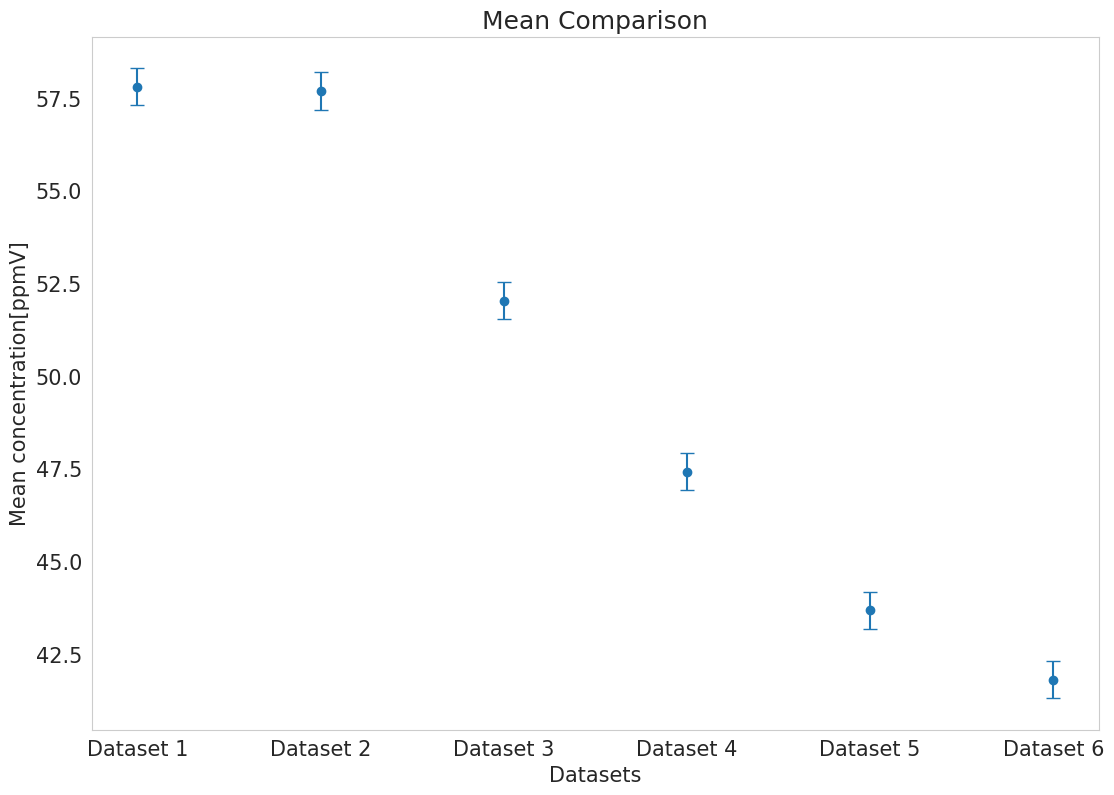

In [12]:
xLabel="Datasets"
yLabel="Mean concentration[ppmV]" 
dimensionless="False"
xAchse = None 
yAchse=None #(72,79) #None 
error_values=0.5 #[0.5,0.2,0.1] #For error values overgive one number which is cast to all values, or an array if specify different errors for each measurements
errorType="absolute"
test = create_means(DataPointsConc,error_values,dimensionless=dimensionless,labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=xAchse,yAchse=yAchse)
#plt.savefig("Mean_comparison.png",test) #To save image


In [ ]:
xLabel="Concentration[-]"
yLabel="Density"
dimensionless="True"
create_pdf(DataPointsConc,dimensionless="True",labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)


In [ ]:
xLabel="Datasets"
yLabel="Concentration [-]"
dimensionless="True"
create_violinplot(DataPointsConc)


In [ ]:
xLabel="Datasets"
yLabel="Concentration [-]"
dimensionless="True"
create_boxplot(DataPointsConc,dimensionless="True",labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)


In [ ]:
xLabel="Datasets"
yLabel="Concentration[ppmV]"
xLabel="Datasets"
yLabel="Concentration[ppmV]"
create_histogram(DataPointsConc,dimensionless="False",labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)


In [ ]:
yLabel=None
xLabel="Concentration[-]"
dimensionless="False"
create_cdf(DataPointsConc,dimensionless=dimensionless,labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)


In [ ]:
test = powerDensityPlot(DataPointsConc,dimensionless="False",plot=True,labels=None,xLabel=None,yLabel=None,xAchse=None,yAchse=None)
plt.savefig("test.png",test)


In [ ]:
from windtunnel.concentration.CompareDatasets import compare_point_concentrations_3
#Give overview/comparison for the data, one plot including of of the plots choosen in the list "functionsForOverview
#Means, Pdf, Cdf, PowerDensity: Number of ts does not matter that much
#Scatterplot: use only 2 ts
#Histogram, Boxplot: would also recommend not to many, because of overlapping of the histograms for comparison, space for the boxplots..

#functionsForOverview = ["all"] #defaul -> all of the available plots
#all_plot_types = [
#        "Histogram", "Pdf", "Cdf", "Means", "BoxPlot", 
#        "QuantilPlot", "ScatterPlot", "ResidualPlot", "Autocorrelation"
#    ]
    
functionsForOverview = [
    "Histogram",
    "BoxPlot"
    #"",<
    "Pdf",
    "Cdf",
    "Means",
    "PowerDensity"
        ]

#Choose which concentration time series/PointObjekts to show in the overview/comparison plot
DataPointsConc = [
    conc_ts[namelist[0]][files[0]],#
    conc_ts[namelist[0]][files[1]],
    #conc_ts[namelist[0]][files[2]],
    #conc_ts[namelist[0]][files[3]],
    #conc_ts[namelist[0]][files[4]],
    #conc_ts[namelist[0]][files[5]]
]

compare_point_concentrations_3(DataPointsConc,functionsForOverview)


In [ ]:
#Concentration fluctuation analysis 
#Intermittency based on threshold, peak2Mean, concentration variance spectral density distribution

#Seettings intermittency calculation
threshold_type="ratio" #ratio, absolute
threshold_method="mean" #mean, std
intermittency_threshold=1.5 #-> if type=ratio,method mean, threshold=threshold*mean(concentration), if type=absolute: threshold=threshold

for name in namelist:
    for file in files:
        conc_ts[name][file].analyze_concentration_fluctuations(dimensionless="False",
                                                       intermittency_threshold=intermittency_threshold,threshold_method=threshold_method)
#power(variance) of concentration changes for different frequencies/timer interval lengths 
#Low-frequency peak: Slow, gradual concentration changes
#High-frequency peak: Rapid, quick concentration fluctuations
#Broad spectrum: Mixed or complex concentration dynamics


In [ ]:
#For completeness also calculate further characteristic metrics of flow/ wind velocity time series (from wtref ts), skewness ..
#print(conc_ts[name][file].calculate_turbulence_intensity(dimensionless="True",returnDistribution="False",returnMetrics="True"))


In [ ]:
##Hier kommt deine für dein Expierment und Daten angepasste Fehlerberrechnung
